# Homework 3 from Martin Gräf, Richard Baumann and Thomas Block

In this Homework we look at the error analysis of the markov chain, that we talked about in the last homework. Therefore as a start we use the artificial hamiltonian, the equations of motion, the estimate of the magnetization, the leapfrog algorithm and the hybrid monte Carlo simulation, that were established in the last homework. Therefore the next lines are identical to the ones in the last homework.

In [2]:
import sys
import os
import io
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import math
import scipy.special as sp

In [3]:
#The magnetization as defined in exercise 3
def O_magnetization(phi, N, beta_J, beta_h):
    return(np.tanh(beta_h+phi))

In [4]:
# The artificial Hamiltonian as defined in exercise 3
def hamiltonian_artificial(p , phi, N, beta_J, beta_h):
    return ((p**2/2)+(phi**2/(2*beta_J))-N*np.log(2*np.cosh(phi+beta_h)))

# phi dot as defined in exercise 3
def phi_dot(p , phi, N, beta_J, beta_h):
    return p

# p dot as defined in exercise 3
def p_dot(p , phi, N, beta_J, beta_h):
    return (-(phi/beta_J)+(N*np.tanh(phi+beta_h)))

In [5]:
# Here could also be a parameter called trajLength, but on the exercise sheet
# it was given that this is supposed to be 1.
def leapfrog(p_start, phi_start, Nmd, N, beta_J, beta_h):
    p_end = p_start
    phi_end = phi_start
    
    # epsilon = trajLength/Nmd
    epsilon = 1/Nmd
    
    # first half step of the leap frog
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end,phi_end, N, beta_J, beta_h)
    
    # Now do all the steps untill the last one:
    for i in range((Nmd)-1):
        p_end = p_end + epsilon*p_dot(p_end, phi_end, N, beta_J, beta_h)
        phi_end = phi_end + epsilon*phi_dot(p_end, phi_end, N, beta_J, beta_h)
        
    # last half step
    p_end = p_end + epsilon * p_dot(p_end,phi_end, N, beta_J, beta_h)
    phi_end = phi_end + (epsilon/2) * phi_dot(p_end ,phi_end, N, beta_J, beta_h)
    
    return (p_end, phi_end)

In [6]:
def generate_phi(N, beta_J, beta_h, Nmd, nTrajs):

    # initilizing some arrays and numbers that are needed later:
    #   With the initial value for phi of 0.9
    phi_array = [0]

    # Array for saving the probabilities (to check if it drops <50%)
    prob = []
    p_step = phi_step = 0

    for traj in range(nTrajs):
        # We are sampling p from the normal distribution...
        p_start = np.random.uniform(0,1)

        # and taking the phi from the last step.
        phi_start = phi_array[-1]

        # calculate the energy before the leapfrog
        energy_start = hamiltonian_artificial(p_start, phi_start, N, beta_J, beta_h)
        
        # now do leapfrog to get new values for p and phi
        p_step, phi_step = leapfrog(p_start, phi_start, Nmd, N, beta_J, beta_h)
        
        # calculate the energy after the leapfrog
        energy_end = hamiltonian_artificial(p_step, phi_step, N, beta_J, beta_h)
        
        # now do accept/reject
        # if the random number is equal/less then the difference between the 
        # energies, accept!
        if np.random.uniform(0,1) <= np.exp(energy_start-energy_end):
            phi_array.append(phi_step)
            prob.append(1.)
        else:  # reject
            phi_array.append(phi_start)
            prob.append(0.)

    # Output if the prob is lower then 0.5, informing when it happend where
    if np.average(np.array(prob))<0.5:
        print("probability smaller then 0.5 at N=", N, " beta_J= ", beta_J, " beta_h= ", beta_h)

    # Return all Phi-Values
    return (np.array(phi_array))

## 1: Plot the first couple hundred trajectories of the MC history of {m}. How do the trajectories differ for the two MCs?

Now that we have carried over the functions form the last exercise sheet, we can start generating markov chains. The parameters, given on the exercise sheet, that should be used to generate said chains are:

* βJ = 0.1; βh = 0.5; n = 5; Nmd = 100
* βJ = 0.1; βh = 0.5; n = 5; Nmd = 4

The magnetization of the first hundred trajectories of these parameters can be seen in the diagram below:

Array 1: 0.6762377819483386 Array 2: 0.5226911277734877


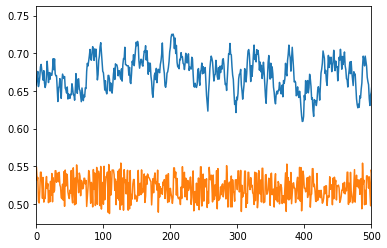

In [7]:
# Generate Phis with the given parameters, deleting thermalization (first 200 entries) and calculate the magnetization
phi_array_1 = np.delete(O_magnetization(generate_phi( 5, 0.02, 0.5, 100, 12800), 5, 0.02, 0.5),np.arange(200))
phi_array_2 = np.delete(O_magnetization(generate_phi( 5, 0.02, 0.5, 4, 12800), 5, 0.02, 0.5),np.arange(200))


# Plotting said values
plt.plot(phi_array_1)
plt.plot(phi_array_2)
plt.xlim(0, 500)

# Average of the values (for comparison)
print("Array 1:", np.average(phi_array_1), "Array 2:", np.average(phi_array_2))

After calculating these magnetizations, we want to estimate the errors, that emerge from this estimate. We take a look at the corrolation of our data, since we no longer have independend data but data that is dependend on the previous step. A unsefull quantity in order to analyze autocorrolations is the autocorrolation function, which is defined as:

\begin{equation}
\Gamma^{(m)}(|k-l|)=<(m(\Phi_k)-<m>)><(m(\Phi_l)-<m>)>
\end{equation}

The autocorrolation function can be implemented with:

\begin{equation}
    \bar{\Gamma}^{(m)} (\tau)= \frac{1}{\#(k, l)} \sum_{(k, l):\tau=|k-l|} (m_k-\bar{m}_N)(m_l-\bar{m}_N)
\end{equation}

An estimator for the normalized autocorrolationc is defined as:

\begin{equation}
c(\tau)= \frac{\bar{\Gamma}^{(m)} (\tau)}{\bar{\Gamma}^{(m)} (0)}
\end{equation}

In [11]:
# Implementation of the Gamma function above
def autocorrolation_function(array, tau, mean):
    sum = 0

    # Summing the individual terms
    for i in range(len(array)-tau):
        sum += (array[i]-mean)*(array[i+tau]-mean)
        
    return (sum/(len(array)-tau))

# Estimating the autocorrolation for tau (gamma(tau)/gamma(0))
def autocorrolation_estimator(array, tau, mean):
    return (autocorrolation_function(array, tau, mean)/autocorrolation_function(array, 0, mean))

## 2: Implement the straightforward estimator C($\tau$) for the normalized autocorrelation function and plot the function of C($\tau$) for your generated data sets.

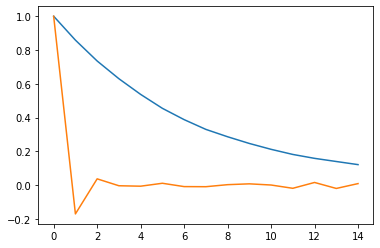

In [45]:
# Initilizing the array for the Values of the estimator
c_array=np.zeros(30).reshape(2, 15)

# Calculating the mean value for the magnetization arrays 
# (because we don`t want to calculate that term a lot of times
# in the function)
mean_array_1=np.average(phi_array_1)
mean_array_2=np.average(phi_array_2)

# Calculating the estimator values for tau \in [1, 15]
for i in range(0, 15):
    c_array[0][i]=autocorrolation_estimator(phi_array_1, i, mean_array_1)
    c_array[1][i]=autocorrolation_estimator(phi_array_2, i, mean_array_2)

# Plotting these values
plt.plot(c_array[0])
plt.plot(c_array[1])

One way to reduce autocorrolations is to block or bin data. That can reduce the neagitve effects of autocorrolation. For that we subdivide our list of values in b lists. We then take the average of that list to measure our quantity (e.g. magnetization).

In [34]:
# Here we split up the original array
def binning(array, b, tau_max):
    split_array = np.array_split(array, b)
    c_array=np.zeros(b*tau_max).reshape(b, tau_max)

    for i in range(tau_max):
        for j in range (b):
            c_array[j][i]=autocorrolation_estimator(split_array[j], i, np.average(split_array[j]))
    
    return (c_array)

## Generate blocked data for b =2, 4, 8, 16, 32, and 64, and calculate the autocorrelation for each blocked list. Does it behave the way you expect? With the blocked lists, estimate the naive standard error with $\frac{\sigma}{\sqrt{(N/b)}}$ and observe the behavior, where $ \sigma $ is the standard deviation of the blocked list.

std at b = 2 0.0003
std at b = 4 0.0004
std at b = 8 0.0005
std at b = 16 0.0008
std at b = 32 0.001
std at b = 64 0.0014


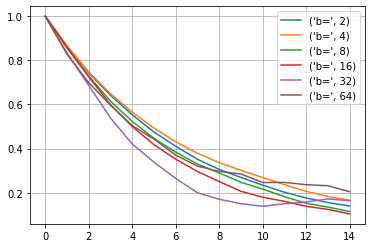

In [63]:
for i in range (1, 7):
    plt.plot(binning(phi_array_1, 2**i, 15)[0], label=("b=", 2**i))
    print("std at b =", 2**i, round(np.std(np.array_split(phi_array_1, 2**i)[0])/((len(phi_array_1)/2**i)**(1/2)), 4))
plt.legend(loc="best")
plt.grid()

std at b = 2 0.0002
std at b = 4 0.0003
std at b = 8 0.0004
std at b = 16 0.0006
std at b = 32 0.0008
std at b = 64 0.0012


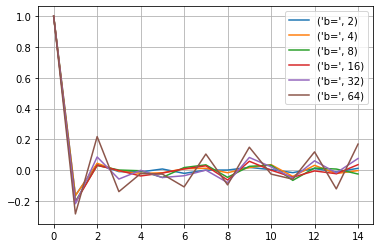

In [62]:
for i in range (1, 7):
    plt.plot(binning(phi_array_2, 2**i, 15)[0], label=("b=", 2**i))
    print("std at b =", 2**i, round(np.std(np.array_split(phi_array_2, 2**i)[0])/((len(phi_array_1)/2**i)**(1/2)), 4))
plt.legend(loc="best")
plt.grid()

### Does it behave the way you expect?

The behaviour kind of how we expected it to look like. The higher b is, the faster the curve converges towards 0. However at higher b the std is higher. 

Now we can implement the bootstrap method to estimate the error of our magnetization. The bootstrap method for a N-long list works in this way:

* 

In [ ]:
def bootstrap_error(phi_array, nBS):  
    n=phi_array.size
    bsmean = np.array([])
    for bs in range (nBS):
        index=np.random.randint(n,size=n) # random bootstrap indices
        bsmean = np.append(bsmean,np.array([phi_array[index[i]] for i in range(n)]).mean())
    return bsmean.std()